# E-commerce

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

## Файлы:

### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя

- 7customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

### olist_orders_dataset.csv —  таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара
— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import datetime as dt
%matplotlib inline 
import calendar

In [3]:
# таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('.\olist_customers_dataset.csv')
#  таблица заказов
orders = pd.read_csv('.\olist_orders_dataset.csv', parse_dates=[3,4,5,6,7])
# товарные позиции, входящие в заказы
items = pd.read_csv('.\olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

# Задание 1
Сколько у нас пользователей, которые совершили покупку только один раз?

In [4]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [5]:
orders.shape

(99441, 8)

In [6]:
#проверка типа данных
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [7]:
orders\
.order_status\
.value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

**Note:**
Для того, чтобы посчитать количество пользователей объединим таблицы orders и customers

In [8]:
customers_orders = customers.merge(orders, on='customer_id')
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


Определим пользователей, у которых customer_unique_id содержит один customer_id

In [9]:
one_customers = customers_orders \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'num_purchases'}) \
    .query('num_purchases == 1')

In [10]:
one_customers.head(2)

,customer_unique_id,num_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [11]:
one_customers.shape

(93099, 2)

Объединим две таблицы: one_customers и customers_orders. Оставим исключительно тех пользователей, которые встречаются в таблице one_customers

In [12]:
customers_orders_once = one_customers.merge(customers_orders, on='customer_unique_id')
customers_orders_once.head(2)

,customer_unique_id,num_purchases,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0000366f3b9a7992bf8c76cfdf3221e2,1,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,2018-05-07 11:11:27,2018-05-07 18:25:44,2018-05-09 12:18:00,2018-05-10 18:02:42,2018-05-15


In [13]:
customers_orders_once.shape

(93099, 13)

In [14]:
#проверка
customers_orders_once.num_purchases.max()

1

In [15]:
# Посмотрим на order_approved_at, на статусы где встречаются пустые значения
customers_orders_once[customers_orders_once.order_approved_at.isna()].order_status.unique()

array(['canceled', 'created', 'delivered'], dtype=object)

In [16]:
# Какое количество нанов встречается в каждом статусе
customers_orders_once[customers_orders_once.order_approved_at.isna()].order_status.value_counts().unique()

array([79, 13,  4], dtype=int64)

**Note**
Большинство товаров имеют статус delivered. Но есть пропущенные значения order_approved_at, хотя статус указано доставлен. Если для статуса: canceled - это относительно понятно. То в случае delivered - нет. Для удобства, эти 14 delivered, я не буду.

### Покупка
Покупкой в данном случае будут считаться : покупки, которые были оплачены (order_approved_at.notna) и не отменены (!='canceled')

In [17]:
answer = customers_orders_once[customers_orders_once.order_approved_at.notna()][customers_orders_once.order_status != "canceled"]

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_33496\1275782589.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  answer = customers_orders_once[customers_orders_once.order_approved_at.notna()][customers_orders_once.order_status != "canceled"]


In [18]:
answer.shape[0]

92549

### Ответ (задание 1):
**92549 пользователей**, которые совершили покупку только один раз

# Задание 2
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [19]:
customers_orders.info() #проверяю типы данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    99441 non-null  object        
 1   customer_unique_id             99441 non-null  object        
 2   customer_zip_code_prefix       99441 non-null  int64         
 3   customer_city                  99441 non-null  object        
 4   customer_state                 99441 non-null  object        
 5   order_id                       99441 non-null  object        
 6   order_status                   99441 non-null  object        
 7   order_purchase_timestamp       99441 non-null  datetime64[ns]
 8   order_approved_at              99281 non-null  datetime64[ns]
 9   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 10  order_delivered_customer_date  96476 non-null  datetime64[ns]
 11  order_estimated

In [20]:
#определяю кол-во пропущенных значений
customers_orders.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**Note**
Есть 2965 заказов без даты доставки (order_delivered_customer_date) Попробую "вытащить" эти данные

In [21]:
customers_orders['not_delivered'] = customers_orders.order_delivered_customer_date.isnull()

In [22]:
customers_orders.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,not_delivered
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,False


In [23]:
customers_orders.shape

(99441, 13)

In [24]:
#фильтрация данных
not_delivered = customers_orders.query("not_delivered != False")

In [25]:
not_delivered.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,not_delivered
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09,True
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24,True


In [26]:
not_delivered.shape

(2965, 13)

### Изучим распределение статусов доставки по месяцам

**Дата:** ожидаемая дату доставки order_estimated_delivery_date

In [27]:
not_del_month = not_delivered \
    .groupby(['order_status', 'order_estimated_delivery_date'], as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'purchases'})
not_del_month.head()

,order_status,order_estimated_delivery_date,purchases
0,approved,2017-03-01,1
1,approved,2017-05-22,1
2,canceled,2016-09-30,1
3,canceled,2016-10-24,1
4,canceled,2016-10-25,1


In [28]:
not_del_month['order_estimated_delivery_date'] = pd.to_datetime(not_del_month.order_estimated_delivery_date).dt.to_period('M').dt.to_timestamp()

In [29]:
not_del_month = not_del_month.rename(columns={'order_estimated_delivery_date':'date'})

In [30]:
not_del_month.head()

,order_status,date,purchases
0,approved,2017-03-01,1
1,approved,2017-05-01,1
2,canceled,2016-09-01,1
3,canceled,2016-10-01,1
4,canceled,2016-10-01,1


Посчитаем сколько в месяц в среднем не доставляется товаров (считаем и среднее и медиану)

Запишем в новую таблицу result_1

In [31]:
result_1 = not_del_month \
    .groupby('date', as_index=False) \
    .agg(mean_purchases=('purchases','mean'), 
         median_purchases=('purchases','median')) \
    .sort_values('date', ascending=False)
result_1.head()

,date,mean_purchases,median_purchases
25,2018-11-01,1.000000,1.0
24,2018-10-01,1.200000,1.0
23,2018-09-01,2.523810,2.0
22,2018-08-01,3.041667,3.0
21,2018-07-01,2.139535,2.0


Посчитаем сколько в месяц в среднем не доставляется товаров для каждого статуса

Полученные результаты запишем в таблицу: detailed_res

In [32]:
detailed_res = not_del_month \
    .groupby(['date', 'order_status'], as_index=False) \
    .agg(mean_purchases=('purchases','mean'), 
         median_purchases=('purchases','median'))\
    .sort_values('date')
detailed_res

,date,order_status,mean_purchases,median_purchases
0,2016-09-01,canceled,1.000000,1.0
1,2016-10-01,canceled,1.000000,1.0
2,2016-10-01,shipped,1.000000,1.0
3,2016-11-01,canceled,2.000000,2.0
4,2016-11-01,invoiced,1.800000,2.0
...,...,...,...,...
112,2018-08-01,processing,1.000000,1.0
115,2018-09-01,canceled,2.722222,2.0
116,2018-09-01,shipped,1.333333,1.0
117,2018-10-01,canceled,1.200000,1.0


In [33]:
detailed_res["year_month"] = detailed_res["date"].dt.to_period("M")

In [34]:
detailed_res.head()

,date,order_status,mean_purchases,median_purchases,year_month
0,2016-09-01,canceled,1.0,1.0,2016-09
1,2016-10-01,canceled,1.0,1.0,2016-10
2,2016-10-01,shipped,1.0,1.0,2016-10
3,2016-11-01,canceled,2.0,2.0,2016-11
4,2016-11-01,invoiced,1.8,2.0,2016-11


In [35]:
sns.set(
    font_scale=1,
    style = 'whitegrid',
    rc = {'figure.figsize':(20,7)}
)

<Axes: title={'center': 'График среднего числа не доставленных заказов'}, xlabel='year_month', ylabel='mean_purchases'>

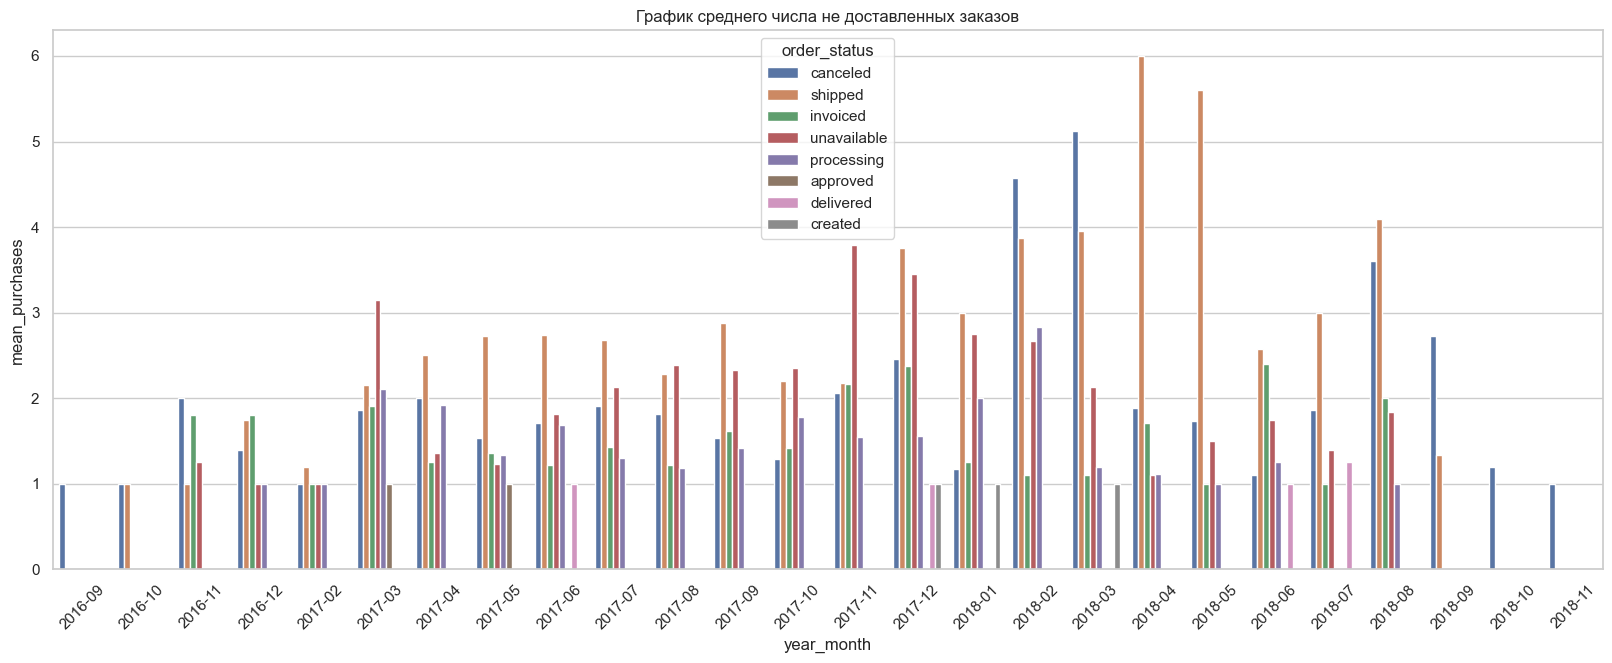

In [36]:
plt.xticks(rotation=45)
plt.title('График среднего числа не доставленных заказов')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов')
sns.barplot(data=detailed_res, x="year_month", y="mean_purchases", hue="order_status")

In [37]:
detailed_res.order_status.value_counts()

canceled       26
shipped        23
invoiced       21
unavailable    21
processing     19
delivered       4
created         3
approved        2
Name: order_status, dtype: int64

Есть отмененные/недоступные заказы Еще есть заказы со статусом shipped, и их достаточно много. Так же представлены и другие статусы. причину понять не могу, возможно сбои в сервисе

# Задание 3
По каждому товару определить, в какой день недели товар чаще всего покупается

Объединим таблицы: orders и items

In [38]:
orders_items = orders\
.merge(items, on='order_id', how='right')\
[['product_id','order_approved_at','order_status']]
orders_items.head()

,product_id,order_approved_at,order_status
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35,delivered
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13,delivered
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30,delivered
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:10:18,delivered
4,ac6c3623068f30de03045865e4e10089,2017-02-04 14:10:13,delivered


In [39]:
orders_items.isnull().sum()

product_id            0
order_approved_at    15
order_status          0
dtype: int64

**Note:** покупка - то, что оплачено и не отменено

In [40]:
orders_items_1 = orders_items[orders_items.order_approved_at.notna()][orders_items.order_status != "canceled"]

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_33496\2454514980.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  orders_items_1 = orders_items[orders_items.order_approved_at.notna()][orders_items.order_status != "canceled"]


In [41]:
orders_items_1.head()

,product_id,order_approved_at,order_status
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 09:45:35,delivered
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 11:05:13,delivered
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:48:30,delivered
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:10:18,delivered
4,ac6c3623068f30de03045865e4e10089,2017-02-04 14:10:13,delivered


In [42]:
#Создание нового столбца, в который будет записываться день недели, в который каждый товар был куплен

orders_items_1['day'] = orders_items_1.order_approved_at.dt.day_name()

In [43]:
result_2 = orders_items_1\
.groupby(['product_id', 'day'], as_index=False)\
.agg(orders=('order_status', 'count'))\
.sort_values(['product_id', 'orders'], ascending=False)\
.groupby('product_id').head(1)

In [44]:
result_2

,product_id,day,orders
60798,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
60797,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3
60794,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60793,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
60791,fff6177642830a9a94a0f2cba5e476d1,Monday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


In [45]:
result_2.orders.describe()

count    32732.000000
mean         1.686820
std          2.435898
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        119.000000
Name: orders, dtype: float64

In [46]:
result_2.sort_values('orders', ascending=False)

,product_id,day,orders
40854,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20038,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15846,422879e10f46682990de24d770e7f83d,Tuesday,89
36366,99a4788cb24856965c36a24e339b6058,Tuesday,82
12998,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
37228,9cfb6da38dab3ad1f5e8cf3189ab6ae1,Sunday,1
37236,9cfca0dc6dd43d12b7de84a5e1e0a429,Wednesday,1
37237,9cfd1f36525a6b46d3e0b7f1e153fa4f,Saturday,1
37239,9d00d68952fff8f837706ac06d1b785b,Friday,1


# Задание 4
 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [47]:
#Объединение таблиц customers и orders
cust_orders = customers.merge(orders, on='customer_id')
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [48]:
#Перевод даты оплаты в нужный формат
cust_orders['order_approved_at '] = cust_orders['order_approved_at'].apply(pd.to_datetime)
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [49]:
#Перевод даты покупки к началу месяца
cust_orders['order_approved_at'] = pd.to_datetime(cust_orders.order_approved_at).dt.to_period('M').dt.to_timestamp()
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-01,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-01,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-01,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-01,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [50]:
#отфильтруем данные
cust_orders_filtr = cust_orders[cust_orders.order_approved_at.notna()][cust_orders.order_status != "canceled"]
cust_orders_filtr.head()

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_33496\3065236380.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cust_orders_filtr = cust_orders[cust_orders.order_approved_at.notna()][cust_orders.order_status != "canceled"]


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-01,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-01,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-01,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-01,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07-29 10:10:09


In [51]:
#Количество покупок для каждого пользователя в месяц
purchases = cust_orders_filtr \
    .groupby(['customer_unique_id', 'order_approved_at'], as_index=False) \
    .agg({'customer_id':'count'}) \
    .rename(columns={'customer_id':'purchases'}) 
purchases.head()

,customer_unique_id,order_approved_at,purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1


In [52]:
purchases = purchases \
    .groupby(['customer_unique_id', 'order_approved_at'], as_index=False) \
    .agg({'purchases':'mean'}) \
    .rename(columns={'purchases':'mean_purchases'})
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0


In [53]:
purchases['weeks'] = purchases.order_approved_at.apply(lambda x: x.days_in_month / 7)
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases,weeks
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0,4.285714


In [54]:
#Определим количество покупок у каждого из пользователей в среднем в неделю (по месяцам)
purchases['week_mounth'] = purchases.mean_purchases / purchases.weeks

In [55]:
#количество в среднем покупок в неделю (по месяцам) приведено ниже
purchases.head()

,customer_unique_id,order_approved_at,mean_purchases,weeks,week_mounth
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1.0,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1.0,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1.0,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1.0,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1.0,4.285714,0.233333


# Задание 5
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [103]:
#объединим две исходные таблицы
customers_orders_1 = customers.merge(orders, on='customer_id')
customers_orders_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [104]:
customers_orders_1['order_purchase_timestamp'] = customers_orders_1['order_purchase_timestamp'].apply(pd.to_datetime)
customers_orders_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [106]:
#группировка по периоду заказа
df_6['order_period'] = df_6.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))
df_6.head()

,customer_unique_id,order_purchase_timestamp,order_period
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07


In [107]:
#фильтрация
df_6 = df_6.query('order_purchase_timestamp > "2017-01-01" & order_period < "2017-12-01"')

In [108]:
#группировка по первой покупке
df_6.set_index('customer_unique_id', inplace=True)
df_6['join_month'] = df_6.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m')) 
df_6.reset_index(inplace=True)
df_6.insert(len(df_6.columns), 'TotalOrders', 0, allow_duplicates=False)
df_6.head()

,customer_unique_id,order_purchase_timestamp,order_period,join_month,TotalOrders
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,2017-05,0
1,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,2017-09,2017-09,0
2,57b2a98a409812fe9618067b6b8ebe4f,2017-11-16 19:29:02,2017-11,2017-11,0
3,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 17:23:20,2017-11,2017-11,0
4,918dc87cd72cd9f6ed4bd442ed785235,2017-09-09 09:54:57,2017-09,2017-09,0


In [109]:
df_6 = df_6.rename(columns={"TotalOrders": "total_orders"})
df_6.head()

,customer_unique_id,order_purchase_timestamp,order_period,join_month,total_orders
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05,2017-05,0
1,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:14:31,2017-09,2017-09,0
2,57b2a98a409812fe9618067b6b8ebe4f,2017-11-16 19:29:02,2017-11,2017-11,0
3,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 17:23:20,2017-11,2017-11,0
4,918dc87cd72cd9f6ed4bd442ed785235,2017-09-09 09:54:57,2017-09,2017-09,0


In [110]:
groups = df_6.groupby(['join_month', 'order_period'])
# количество уникальных пользователей, общее количество заказов, выручка за период
cohorts = groups.agg({'customer_unique_id': pd.Series.nunique, 'total_orders': pd.Series.count})
cohorts.rename(columns={'customer_unique_id': 'total_users'}, inplace=True)
cohorts.head()

total_users  total_orders
join_month order_period                           
2017-01    2017-01               765           800
           2017-02                 3             3
           2017-03                 2             2
           2017-04                 1             1
           2017-05                 3             3

In [111]:
def cohort_period(df):
 df['cohort_period'] = np.arange(len(df)) + 1 # отсчет с 1
 return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_33496\3246311406.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cohorts = cohorts.groupby(level=0).apply(cohort_period)


total_users  total_orders  cohort_period
join_month order_period                                          
2017-01    2017-01               765           800              1
           2017-02                 3             3              2
           2017-03                 2             2              3
           2017-04                 1             1              4
           2017-05                 3             3              5

In [112]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['join_month', 'cohort_period'], inplace=True)

In [113]:
# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['total_users'].groupby(level=1).first()
cohort_group_size.head()

cohort_period
1    765
2      3
3      2
4      1
5      3
Name: total_users, dtype: int64

In [114]:
cohorts['total_users'].head()

join_month  cohort_period
2017-01     1                765
            2                  3
            3                  2
            4                  1
            5                  3
Name: total_users, dtype: int64

In [115]:
cohorts['total_users'].unstack(1)

cohort_period,1,2,3,4,5,6,7,8,9,10,11
join_month,,,,,,,,,,,
2017-01,765.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN
2017-04,2353.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN
2017-07,3895.0,20.0,14.0,10.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# переиндексируем DataFrame
cohorts.reset_index(inplace=True)#транспонировали, просто поменяв местами join_month и cohort_period и далее добавим axis=1
cohorts.set_index(['join_month','cohort_period'], inplace=True) 
#ряд содержаший размер каждой когорты join_month
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohorts['total_users'].unstack(0)
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']]

join_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.003922,0.002283,0.004932,0.005950,0.005006,0.004779,0.005135,0.006931,0.006778,0.006935,0.005476,NaN
3,0.002614,0.002854,0.003794,0.002125,0.005006,0.003504,0.003594,0.003346,0.005326,0.002461,NaN,NaN
4,0.001307,0.001142,0.003794,0.001700,0.003893,0.004141,0.002567,0.002629,0.002905,NaN,NaN,NaN
5,0.003922,0.003995,0.003414,0.003400,0.003059,0.002549,0.002824,0.003585,NaN,NaN,NaN,NaN
6,0.001307,0.001142,0.001517,0.002550,0.003337,0.003823,0.002054,NaN,NaN,NaN,NaN,NaN
7,0.005229,0.002283,0.001517,0.003400,0.004171,0.003823,NaN,NaN,NaN,NaN,NaN,NaN
8,0.001307,0.001712,0.003035,0.002975,0.001669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.001307,0.001712,0.003414,0.002975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Задание 5 (вариант 2)

In [129]:
df = customers.merge(orders, on='customer_id')
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [130]:
df_cust = df.loc[:, ['customer_unique_id', 'order_approved_at', 'order_status']]
df_cust.head() #отбор нужных столбцов

,customer_unique_id,order_approved_at,order_status
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,delivered
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,delivered


In [131]:
df_cust = df_cust[df_cust.order_approved_at.notna()][df_cust.order_status != "canceled"]
df_cust.head()

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_33496\3097668903.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cust = df_cust[df_cust.order_approved_at.notna()][df_cust.order_status != "canceled"]


,customer_unique_id,order_approved_at,order_status
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,delivered
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,delivered


In [132]:
df_cust.dtypes

customer_unique_id            object
order_approved_at     datetime64[ns]
order_status                  object
dtype: object

In [133]:
df_cust["order_approved_at_months"] = df_cust.order_approved_at.apply(lambda x : x.strftime('%Y-%m'))           
# dt.to_period("M")
df_cust.head(2)

,customer_unique_id,order_approved_at,order_status,order_approved_at_months
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01


In [134]:
df_cust = df_cust.query(('"2016-12" < order_approved_at_months < "2018-04"'))
df_cust.head(2)

,customer_unique_id,order_approved_at,order_status,order_approved_at_months
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01


In [135]:
# Определим, в каком месяце каждый пользователь совершил свою первую покупку
first_time = df_cust\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_approved_at_months': 'min'})\
    .rename(columns = ({'order_approved_at_months' : 'first_purchase_date'}))
first_time.head()

,customer_unique_id,first_purchase_date
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,00053a61a98854899e70ed204dd4bafe,2018-02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03


In [136]:
#Объединим данные о месяце первой покупки к таблице с данными о клиентах и заказах
cus_first = df_cust.merge(first_time, how = 'inner', on = 'customer_unique_id')
cus_first.head()

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01,2018-01
2,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered,2018-03,2018-03
3,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:25:11,delivered,2017-09,2017-09
4,4c93744516667ad3b8f1fb645a3116a4,2017-10-15 13:05:29,delivered,2017-10,2017-09


In [137]:
cus_first.dtypes

customer_unique_id                  object
order_approved_at           datetime64[ns]
order_status                        object
order_approved_at_months            object
first_purchase_date                 object
dtype: object

In [138]:
# Перевод колонки с датами  order_approved_at_months, first_purchase_date в формат datetime
cus_first['order_approved_at_months'] = pd.to_datetime(cus_first.order_approved_at_months)
cus_first['first_purchase_date'] = pd.to_datetime(cus_first.first_purchase_date)
cus_first.dtypes

customer_unique_id                  object
order_approved_at           datetime64[ns]
order_status                        object
order_approved_at_months    datetime64[ns]
first_purchase_date         datetime64[ns]
dtype: object

In [139]:
 #новая колонка: разница между датой покупки (order_approved_at_months) и датой первой покупки (first_purchase_date)
cus_first['diff'] = cus_first.order_approved_at_months - cus_first.first_purchase_date
cus_first.head()

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date,diff
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,delivered,2017-05-01,2017-05-01,0 days
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,delivered,2018-01-01,2018-01-01,0 days
2,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,delivered,2018-03-01,2018-03-01,0 days
3,4c93744516667ad3b8f1fb645a3116a4,2017-09-14 18:25:11,delivered,2017-09-01,2017-09-01,0 days
4,4c93744516667ad3b8f1fb645a3116a4,2017-10-15 13:05:29,delivered,2017-10-01,2017-09-01,30 days


In [140]:
#Покупки, совершенные на 3й месяц после первой покупки        
third_month = cus_first.loc[cus_first['diff'] <= '92 days'].loc[cus_first['diff'] >= '89 days']
third_month.head() 

,customer_unique_id,order_approved_at,order_status,order_approved_at_months,first_purchase_date,diff
435,4e65032f1f574189fb793bac5a867bbc,2017-06-02 09:50:10,delivered,2017-06-01,2017-03-01,92 days
436,4e65032f1f574189fb793bac5a867bbc,2017-06-24 17:00:07,delivered,2017-06-01,2017-03-01,92 days
823,39104edef5e46d7b8c61848cc95e6d97,2017-10-01 10:24:04,delivered,2017-10-01,2017-07-01,92 days
949,25f24493ded5ebebc26a69b5db344e35,2018-02-26 09:50:00,delivered,2018-02-01,2017-11-01,92 days
997,b8b3c435a58aebd788a477bed8342910,2017-08-24 10:35:22,delivered,2017-08-01,2017-05-01,92 days


In [141]:
#Когорта с кол-вом покупок 
cohorts = third_month\
    .groupby(['first_purchase_date','diff'], as_index = False)\
    .agg({'customer_unique_id':'count'})\
    .rename(columns = ({'customer_unique_id' : 'third_month_count'}))
cohorts

,first_purchase_date,diff,third_month_count
0,2017-01-01,90 days,1
1,2017-02-01,89 days,3
2,2017-03-01,92 days,11
3,2017-04-01,91 days,5
4,2017-05-01,92 days,14
5,2017-06-01,92 days,13
6,2017-07-01,92 days,8
7,2017-08-01,92 days,11
8,2017-09-01,91 days,18
9,2017-10-01,92 days,4


In [142]:
# Сформируем когорты с кол-вом первых покупок
first_month_customers = cus_first\
    .groupby('first_purchase_date', as_index = False)\
    .agg({'customer_unique_id' : 'count'})\
    .rename(columns = ({'customer_unique_id' : 'first_month_count'}))
first_month_customers.head()

,first_purchase_date,first_month_count
0,2017-01-01,789
1,2017-02-01,1792
2,2017-03-01,2742
3,2017-04-01,2414
4,2017-05-01,3779


In [143]:
# записи о первых покупках в 2017 году
first_month_2017 = first_month_customers.query('"2016-12" < first_purchase_date < "2018-01"').reset_index(drop = True)
first_month_2017

,first_purchase_date,first_month_count
0,2017-01-01,789
1,2017-02-01,1792
2,2017-03-01,2742
3,2017-04-01,2414
4,2017-05-01,3779
5,2017-06-01,3280
6,2017-07-01,3984
7,2017-08-01,4382
8,2017-09-01,4314
9,2017-10-01,4543


In [144]:
# объединение таблиц с когортами в один
res = first_month_2017.merge(cohorts, how = 'inner', on = 'first_purchase_date')
res

,first_purchase_date,first_month_count,diff,third_month_count
0,2017-01-01,789,90 days,1
1,2017-02-01,1792,89 days,3
2,2017-03-01,2742,92 days,11
3,2017-04-01,2414,91 days,5
4,2017-05-01,3779,92 days,14
5,2017-06-01,3280,92 days,13
6,2017-07-01,3984,92 days,8
7,2017-08-01,4382,92 days,11
8,2017-09-01,4314,91 days,18
9,2017-10-01,4543,92 days,4


In [145]:
res['retention'] = round(100 * res.third_month_count / res.first_month_count, 2)
res

,first_purchase_date,first_month_count,diff,third_month_count,retention
0,2017-01-01,789,90 days,1,0.13
1,2017-02-01,1792,89 days,3,0.17
2,2017-03-01,2742,92 days,11,0.40
3,2017-04-01,2414,91 days,5,0.21
4,2017-05-01,3779,92 days,14,0.37
5,2017-06-01,3280,92 days,13,0.40
6,2017-07-01,3984,92 days,8,0.20
7,2017-08-01,4382,92 days,11,0.25
8,2017-09-01,4314,91 days,18,0.42
9,2017-10-01,4543,92 days,4,0.09


In [146]:
res.retention.max()

0.42

### Ответ (задание 5)
Когорта с самым высоким retention на 3й месяц - пользователи, сделавшие первую покупку в сентябре 2017 года, их retention составляет 0.42%. Показатель довольно низкий. Но если вспомнить первое задание, то у нас было много покупателей, которые совершили покупку только один раз

# Задание 6
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [147]:
customer_with_order = customers.merge(orders, on='customer_id')
customer_with_order.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [148]:
df_orders_items = customer_with_order.merge(items[['order_id', 'order_item_id', 'product_id', 'price']], on='order_id', how='left')
df_orders_items.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1.0,4aa6014eceb682077f9dc4bffebc05b0,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1.0,bd07b66896d6f1494f5b86251848ced7,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1.0,9391a573abe00141c56e38d84d7d5b3b,230.00


In [149]:
df_cut = df_orders_items.loc[:, ['customer_unique_id', 'order_id', 'order_approved_at', 'order_status', 'price']]
df_cut.head()

,customer_unique_id,order_id,order_approved_at,order_status,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,delivered,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,delivered,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,delivered,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,delivered,230.00


In [150]:
df_cut_filter = df_cut[(df_cut['order_approved_at'] > "2016-12-31") & (df_cut['order_approved_at'] < '2018-01-01')]
df_cut_filter.head()

,customer_unique_id,order_id,order_approved_at,order_status,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90
10,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30
12,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00


In [151]:
#Добавляем столбец с датой последней покупки. Принцип того, что такое "покупка", взято такой же, как в первом вопросе проекта.

last_order = df_cut_filter \
    .query('order_approved_at != "" and order_status != ["canceled"]') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at': 'max'}) \
    .rename(columns={'order_approved_at': 'last_order'})
last_order

,customer_unique_id,last_order
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:43:26
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:30:22
...,...,...
43395,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:47:44
43396,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16
43397,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20
43398,ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44


In [152]:
df_with_last = df_cut_filter.merge(last_order[['customer_unique_id', 'last_order']], on='customer_unique_id', how='left')
df_with_last.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17


In [153]:
# Добавил колонку с кол-вом прошедших дней с момента последнего заказа до наст.времени 20.01.23 2:13

df_with_last['days_last_order'] = ((pd.Timestamp.now().normalize() - df_with_last.last_order).dt.days).astype('Int64')
df_with_last.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2120
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,1968
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,1936
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,1925
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2004


In [154]:
# Общее кол-во покупок по пользователю

total_purchases = df_with_last \
    .query('order_approved_at != "" and order_status != ["canceled"]') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .rename(columns={'order_id': 'total_purchases'}) \
    .sort_values('total_purchases', ascending=False)
total_purchases.head()

,customer_unique_id,total_purchases
23908,8d50f5eadf50201ccdcedfb9e2ac8455,10
3262,12f5d6e1cbf93dafd9dcc19095df0b3d,6
4665,1b6c7548a2a1f9037c1fd3ddfed95f33,5
17087,6469f99c1f9dfae7733b25662e7f1782,5
12214,47c1a3033b8b77b3ab6e109eb4d5fdf3,5


In [155]:
total_purchases.shape

(43400, 2)

In [156]:
df_with_last_total = df_with_last.merge(total_purchases[['customer_unique_id', 'total_purchases']], on='customer_unique_id', how='left')

df_with_last_total.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order,total_purchases
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2120,1.0
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,1968,2.0
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,1936,1.0
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,1925,1.0
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2004,1.0


In [157]:
df_with_last_total.dtypes

customer_unique_id            object
order_id                      object
order_approved_at     datetime64[ns]
order_status                  object
price                        float64
last_order            datetime64[ns]
days_last_order                Int64
total_purchases              float64
dtype: object

In [158]:
df_with_last_total.total_purchases = df_with_last_total.total_purchases.astype('Int32')

In [159]:
df_with_last_total.isna().sum()

customer_unique_id      0
order_id                0
order_approved_at       0
order_status            0
price                 465
last_order            243
days_last_order       243
total_purchases       243
dtype: int64

In [160]:
df_with_last_total.dropna(subset=['total_purchases'], inplace=True)

In [161]:
df_with_last_total.dropna(subset=['price'], inplace=True)

In [162]:
df_with_last_total.isna().sum()

customer_unique_id    0
order_id              0
order_approved_at     0
order_status          0
price                 0
last_order            0
days_last_order       0
total_purchases       0
dtype: int64

In [163]:
df_with_last_total.order_status.unique()

array(['delivered', 'shipped', 'invoiced', 'processing', 'approved',
       'canceled'], dtype=object)

In [164]:
df_with_last_total = df_with_last_total[df_with_last_total['order_status'] != "canceled"]

In [165]:
# Добавляю последнюю колонку с суммой покупок, перед тем, как делать кластеризацию.

total_revenue = df_with_last_total \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'total_revenue'}) \
    .sort_values('total_revenue', ascending=False)
total_revenue.head()

,customer_unique_id,total_revenue
1727,0a0a92112bd4c708ca5fde585afaa872,13440.0
36680,da122df9eeddfedc1dc1f5349a1a690c,7388.0
37050,dc4802a71eae9be1dd28f5d788ceb526,6735.0
42822,ff4159b92c40ebe40454e3e6a7c35ed6,6499.0
10765,4007669dec559734d6f53e029e360987,5934.6


In [166]:

df_with_last_total = df_with_last_total.merge(total_revenue[['customer_unique_id', 'total_revenue']], on='customer_unique_id', how='left')
df_with_last_total.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,days_last_order,total_purchases,total_revenue
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2120,1,124.99
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,1968,2,506.52
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,1936,1,19.90
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,1925,1,25.30
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2004,1,99.00


In [167]:
rfm = df_with_last_total #создание новой переменной (для удобства)

Чтобы провести RFM-анализ, определяю параметры: recency (R), frequency (F), monetary (M).

Под поставленную задачу подойдет следующее:

- R - время от последней покупки пользователя до текущей даты

- F - суммарное количество покупок у пользователя за всё время

- M - сумма покупок за всё время

In [168]:
rfm_1 = rfm.rename(columns={'days_last_order': 'recency', 'total_purchases': 'frequency', 'total_revenue': 'monetary'})
rfm_1.head()

,customer_unique_id,order_id,order_approved_at,order_status,price,last_order,recency,frequency,monetary
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,delivered,124.99,2017-05-16 15:22:12,2120,1,124.99
1,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,delivered,259.90,2017-10-15 13:05:29,1968,2,506.52
2,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,delivered,19.90,2017-11-16 19:55:41,1936,1,19.90
3,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,delivered,25.30,2017-11-27 18:01:20,1925,1,25.30
4,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,delivered,99.00,2017-09-09 10:10:17,2004,1,99.00


c:\Users\Ann Zalivatskaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Ann Zalivatskaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='recency', ylabel='Count'>

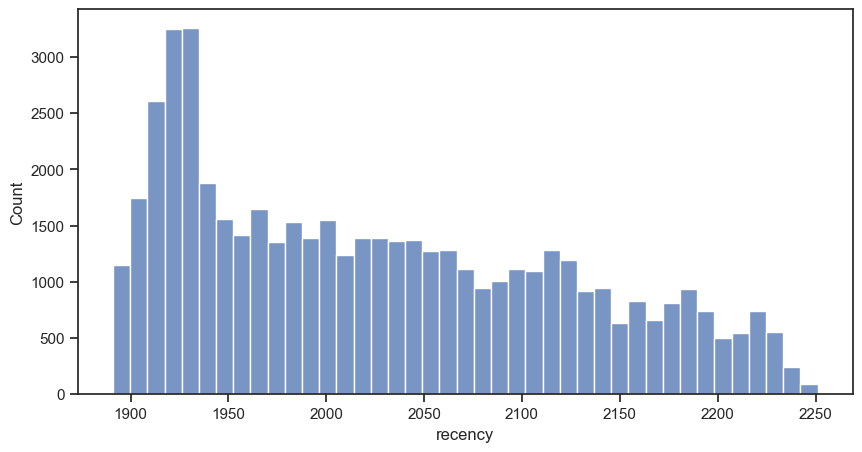

In [170]:
plt.figure(figsize=(10,5))
sns.histplot(rfm_1.recency) #распределение "recency" отличается от нормального

<Axes: xlabel='monetary', ylabel='Count'>

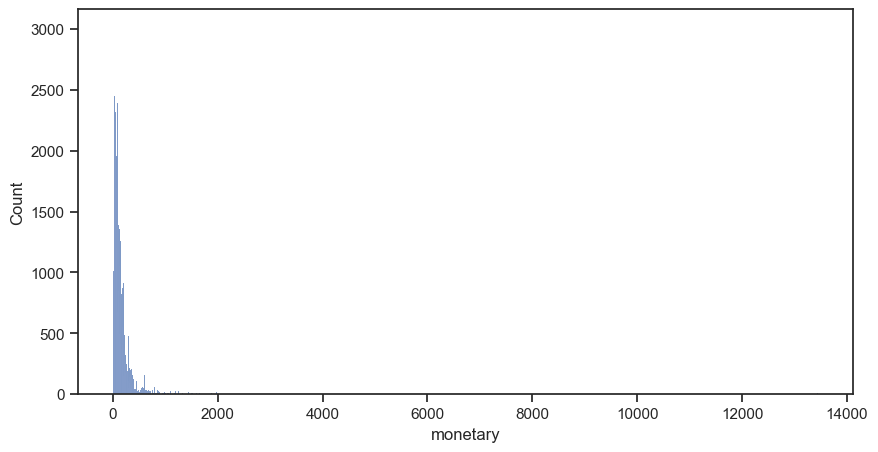

In [171]:
plt.figure(figsize=(10,5))
sns.histplot(rfm_1.monetary) #распределение параметра "monetary" еще "хуже"

c:\Users\Ann Zalivatskaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Ann Zalivatskaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<Axes: xlabel='frequency', ylabel='Count'>

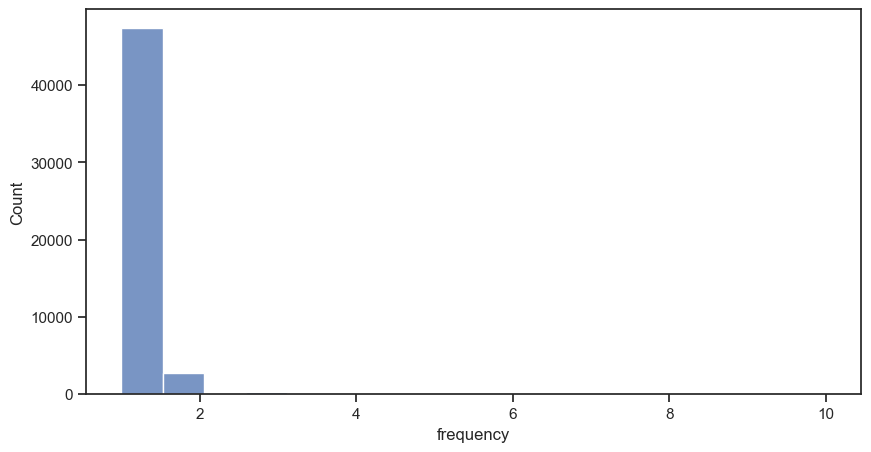

In [172]:
plt.figure(figsize=(10,5))
sns.histplot(rfm_1.frequency)

In [175]:
rfm_1.frequency.value_counts()

1     47458
2      2695
3       275
4        69
5        29
10        9
6         6
Name: frequency, dtype: Int64

In [174]:
# Распределение параметра "frequency"

rfm_1.frequency.value_counts(normalize=True)

1        0.939
2     0.053323
3     0.005441
4     0.001365
5     0.000574
10    0.000178
6     0.000119
Name: frequency, dtype: Float64

**Note:** В параметре "frequency" большая часть пользователей совершали всего лишь одну покупку

In [180]:
rfm_1['r_score'] = pd.qcut(rfm_1.recency, 3)
rfm_1.r_score

0          (2067.0, 2251.0]
1          (1961.0, 2067.0]
2        (1890.999, 1961.0]
3        (1890.999, 1961.0]
4          (1961.0, 2067.0]
                ...        
50536      (2067.0, 2251.0]
50537      (2067.0, 2251.0]
50538    (1890.999, 1961.0]
50539    (1890.999, 1961.0]
50540    (1890.999, 1961.0]
Name: r_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(1890.999, 1961.0] < (1961.0, 2067.0] < (2067.0, 2251.0]]

In [182]:
rfm_1['r_score'] = pd.qcut(rfm_1.recency, 3, labels=[3,2,1])

In [183]:
rfm_1['m_score'] = pd.qcut(rfm_1.monetary, 3)
rfm_1.m_score

0          (59.94, 139.8]
1        (139.8, 13440.0]
2          (2.289, 59.94]
3          (2.289, 59.94]
4          (59.94, 139.8]
               ...       
50536      (59.94, 139.8]
50537      (2.289, 59.94]
50538      (2.289, 59.94]
50539    (139.8, 13440.0]
50540      (2.289, 59.94]
Name: m_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(2.289, 59.94] < (59.94, 139.8] < (139.8, 13440.0]]

In [184]:
rfm_1['m_score'] = pd.qcut(rfm_1.monetary, 3, labels=[1,2,3])
rfm_1.m_score

0        2
1        3
2        1
3        1
4        2
        ..
50536    2
50537    1
50538    1
50539    3
50540    1
Name: m_score, Length: 50541, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [185]:
rfm_1['f_score'] = pd.cut(rfm_1.frequency, [0,1,2,np.inf])
rfm_1.f_score

0        (0.0, 1.0]
1        (1.0, 2.0]
2        (0.0, 1.0]
3        (0.0, 1.0]
4        (0.0, 1.0]
            ...    
50536    (0.0, 1.0]
50537    (0.0, 1.0]
50538    (0.0, 1.0]
50539    (0.0, 1.0]
50540    (0.0, 1.0]
Name: f_score, Length: 50541, dtype: category
Categories (3, interval[float64, right]): [(0.0, 1.0] < (1.0, 2.0] < (2.0, inf]]

In [186]:
rfm_1['f_score'] = pd.cut(rfm_1.frequency, [0,1,2,np.inf], labels=[1,2,3])
rfm_1.f_score

0        1
1        2
2        1
3        1
4        1
        ..
50536    1
50537    1
50538    1
50539    1
50540    1
Name: f_score, Length: 50541, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [187]:
rfm_1 = rfm_1[['customer_unique_id','r_score','f_score','m_score', 'recency', 'frequency', 'monetary' ]].drop_duplicates()

In [188]:
rfm_1['score_int'] = rfm_1['r_score'].astype(int) + rfm_1['f_score'].astype(int) + rfm_1['m_score'].astype(int)

In [189]:
rfm_1['score'] = rfm_1['r_score'].astype(str) + rfm_1['f_score'].astype(str) + rfm_1['m_score'].astype(str)

In [190]:
rfm_1.sort_values('score_int', ascending=False)

,customer_unique_id,r_score,f_score,m_score,recency,frequency,monetary,score_int,score
7215,da2b78576894a7f95d45bfd20250cc54,3,3,3,1918,3,374.15,9,333
4574,9947c0ed8bf41cd508a78da36abc1d41,3,3,3,1958,3,149.50,9,333
6952,e12f7f1e96f1f9f6361572028a1fad5a,3,3,3,1953,3,679.70,9,333
11167,b59e4bb4efe81ba0f7d30cff6734f9a2,3,3,3,1918,3,250.62,9,333
38871,e30b83af13d6ff0b0f427b2a67c43b39,3,3,3,1919,3,763.40,9,333
...,...,...,...,...,...,...,...,...,...
35308,c0955a0a7cd0cbaf66ee32b50d136132,1,1,1,2128,1,47.90,3,111
46056,57953ff2a999a79ace45303decbc6245,1,1,1,2189,1,46.99,3,111
4110,7b8b31516cdb407eaed1ce4f2d30c448,1,1,1,2078,1,31.90,3,111
28947,6e279371383dfb449436fd7edd27e803,1,1,1,2162,1,13.99,3,111


In [191]:
seg_map = {
    r'333': 'VIP',
    r'33[1-2]': 'Выгодные',
    r'32[1-3]': 'Потенциально выгодные',
    r'31[1-3]': 'Новенькие',
    r'23[1-3]': 'Спящие выгодные',
    r'22[2-3]': 'Спящие выгодные',
    r'21[1-3]': 'Спящие',
    r'221': 'Спящие',
    r'13[2-3]': 'Уходящие выгодные',
    r'12[2-3]': ' Уходящие',
    r'131': ' Уходящие',
    r'11[1-3]': 'Потерянные',
    r'121': 'Потерянные'
}

In [193]:
rfm_1['segment'] = rfm_1['score'].replace(seg_map, regex=True)
rfm_1.head()

,customer_unique_id,r_score,f_score,m_score,recency,frequency,monetary,score_int,score,segment
0,861eff4711a542e4b93843c6dd7febb0,1,1,2,2120,1,124.99,4,112,Потерянные
1,4c93744516667ad3b8f1fb645a3116a4,2,2,3,1968,2,506.52,7,223,Спящие выгодные
2,57b2a98a409812fe9618067b6b8ebe4f,3,1,1,1936,1,19.90,5,311,Новенькие
3,2a7745e1ed516b289ed9b29c7d0539a5,3,1,1,1925,1,25.30,5,311,Новенькие
4,918dc87cd72cd9f6ed4bd442ed785235,2,1,2,2004,1,99.00,5,212,Спящие


In [195]:
rfm_1.segment.value_counts()

Потерянные               14191
Спящие                   13864
Новенькие                13742
Спящие выгодные            425
Потенциально выгодные      408
 Уходящие                  282
VIP                         28
Уходящие выгодные           19
Выгодные                     1
Name: segment, dtype: int64

In [196]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatch

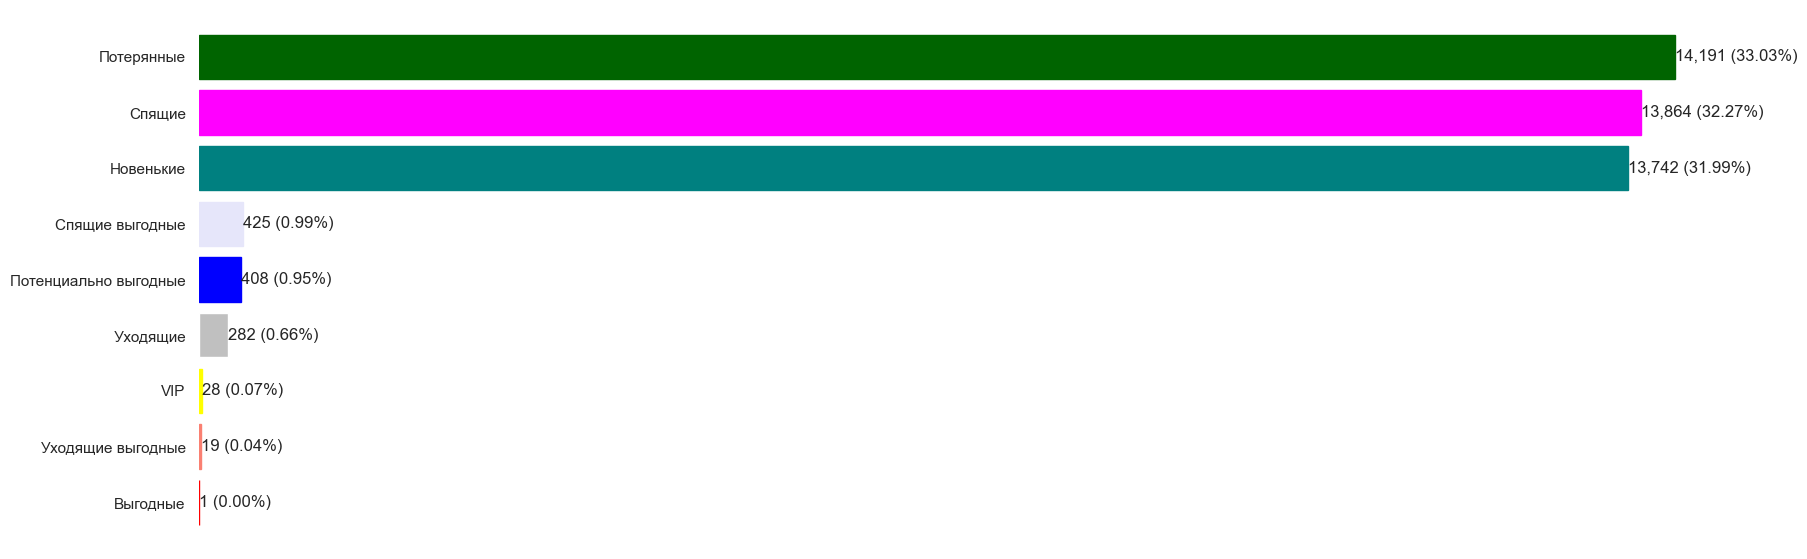

In [198]:
segments = rfm_1['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments)),
              segments,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments)))
ax.set_yticklabels(segments.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments.index[i] in ['VIP']:
            bar.set_color('yellow')
        elif segments.index[i] == 'Выгодные':
            bar.set_color('red')
        elif segments.index[i] == 'Потенциально выгодные':
            bar.set_color('blue')
        elif segments.index[i] == 'Новенькие':
            bar.set_color('teal')
        elif segments.index[i] == 'Спящие выгодные':
            bar.set_color('lavender')
        elif segments.index[i] == 'Спящие':
            bar.set_color('magenta')
        elif segments.index[i] == 'Уходящие выгодные':
            bar.set_color('salmon')
        elif segments.index[i] == 'Уходящие':
            bar.set_color('pink')
        elif segments.index[i] == 'Потерянные':
            bar.set_color('darkgreen')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:.2f}%)'.format(int(value),
                                   float(value*100/segments.sum())),
                va='center',
                ha='left'
               )

plt.show()

По барплоту мы видим, что основная часть (~ 30-33%) наших пользователей находится в категориях:

- потерянные (33%)
- спящие (32.27)
- новенькикие (31.99)
Я ничего не знаю о том, что продается. Возможно товары специфичны. Которые не обязательно "часто" покупать

Было потеряно много клиентов. Есть вариант, что рекламная кампания либо не настроена, либо стратегия выбрана плохо.

Так же на продажи могут влить: качество продукта. Или например сервис? Можно сконцентрироваться на спящих выгодных и потенциально выгодных

**возможные варианты:**

- скидка для новых клиентов на вторую покупку
- система бонусов : программа лояльности
- настроить рекомендации товаров если проблема в сервисе, тогда надо выявить эту проблему например, настроить оформить обратную связь, чтобы клиент оценивал качество заказа и качество доставки заказа -устраивать какие-нибудь распродажи, для зарег. клиентов. Объявление приходит на почту например.